<a href="https://colab.research.google.com/github/philipp-hellwig/evolution-language-simulation/blob/main/Bayesian_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Incomplete Information

As off now, the simulation was a white box for the agents: they had direct  access to other agents' reputations. However, this is an unrealistic assumption: In many cases, agents may not have direct access

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.distributions as td
import seaborn as sns
from tqdm import tqdm
from IPython.display import display
from agent_class import Agent

In [84]:
class BayesianAgent(Agent):
    laplace_smoothing = 0.0001
    def __init__(self,  *args, **kwargs):
        super(BayesianAgent, self).__init__(*args, **kwargs)
        self.beta_communicate = self.prior_communication

    def set_cohort(self, cohort: list):
        smoothing = BayesianAgent.laplace_smoothing
        self.beta_communicate = {agent: [self.communication+smoothing, (6-self.communication)+smoothing] for agent in cohort if agent is not self}

    def likelihood_communicate(self, other):
        a, b = self.beta_communicate[other]
        return st.beta.rvs(a, b)

    # rewrite food opportunity interaction:
    def found_food(self, other):
        # decide to communicate or not:
        if st.bernoulli(self.likelihood_communicate(other)).rvs(1):
            # other also has to be willing to communicate
            if st.bernoulli(other.likelihood_communicate(self)).rvs(1):
                # decide to try to steal food or not
                if st.bernoulli(self.prior_malintent).rvs(1):
                    # other has good intentions:
                    if not st.bernoulli(other.prior_malintent).rvs(1):
                        self.food_counter += BayesianAgent.food_stealing
                        self.update_beta_communicate(other, positive_outcome=True)
                        other.update_beta_communicate(self, positive_outcome=False)
                    # if other also wants to steal the food:
                    else:
                        winner = np.random.choice([self, other])
                        winner.food_counter += BayesianAgent.food_stealing
                        winner.update_beta_communicate(winner, loser, positive_outcome=True)
                        loser = {self, other}.difference({winner})
                        loser.update_beta_communicate(loser, winner, positive_outcome=False)
                else:
                    if st.bernoulli(other.prior_malintent).rvs(1):
                        other.food_counter += BayesianAgent.food_stealing
                        other.update_beta_communicate(self, positive_outcome=True)
                        self.update_beta_communicate(other, positive_outcome=False)
                    else:
                        # share food:
                        self.food_counter += BayesianAgent.food_sharing
                        other.food_counter += BayesianAgent.food_sharing
                        self.update_beta_communicate(other, positive_outcome=True)
                        other.update_beta_communicate(self, positive_outcome=True)

            else:
                self.food_counter += BayesianAgent.food_individual_consumption
        else:
            self.food_counter += BayesianAgent.food_individual_consumption

    def update_beta_communicate(self, other, positive_outcome: bool):
        if positive_outcome:
            self.beta_communicate[other][0] += 1
        else:
            self.beta_communicate[other][1] += 1

    def gossip(self, other):
        if st.bernoulli(self.prior_communication).rvs(1):
            pass


[1.0001, 5.0001]


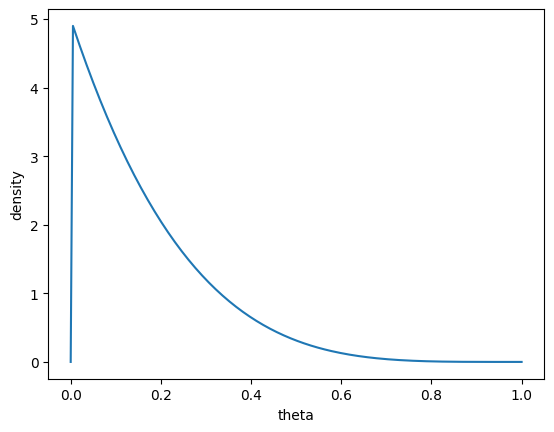

In [85]:
agents = [BayesianAgent(mu=0.01) for _ in range(10)]
for agent in agents:
    agent.set_cohort(agents)

# for example, the first agents parameters for the beta distribution to communicate with the second agent are:
print(agents[0].beta_communicate[agents[1]])

a, b = agents[0].beta_communicate[agents[1]]

beta_communicate = np.linspace(0,1,200)

_ = plt.plot(beta_communicate, st.beta.pdf(beta_communicate, a, b))
_ = plt.xlabel("theta")
_ = plt.ylabel("density")

After communicating with a positive outcome with another agent, the distribution gets updated:

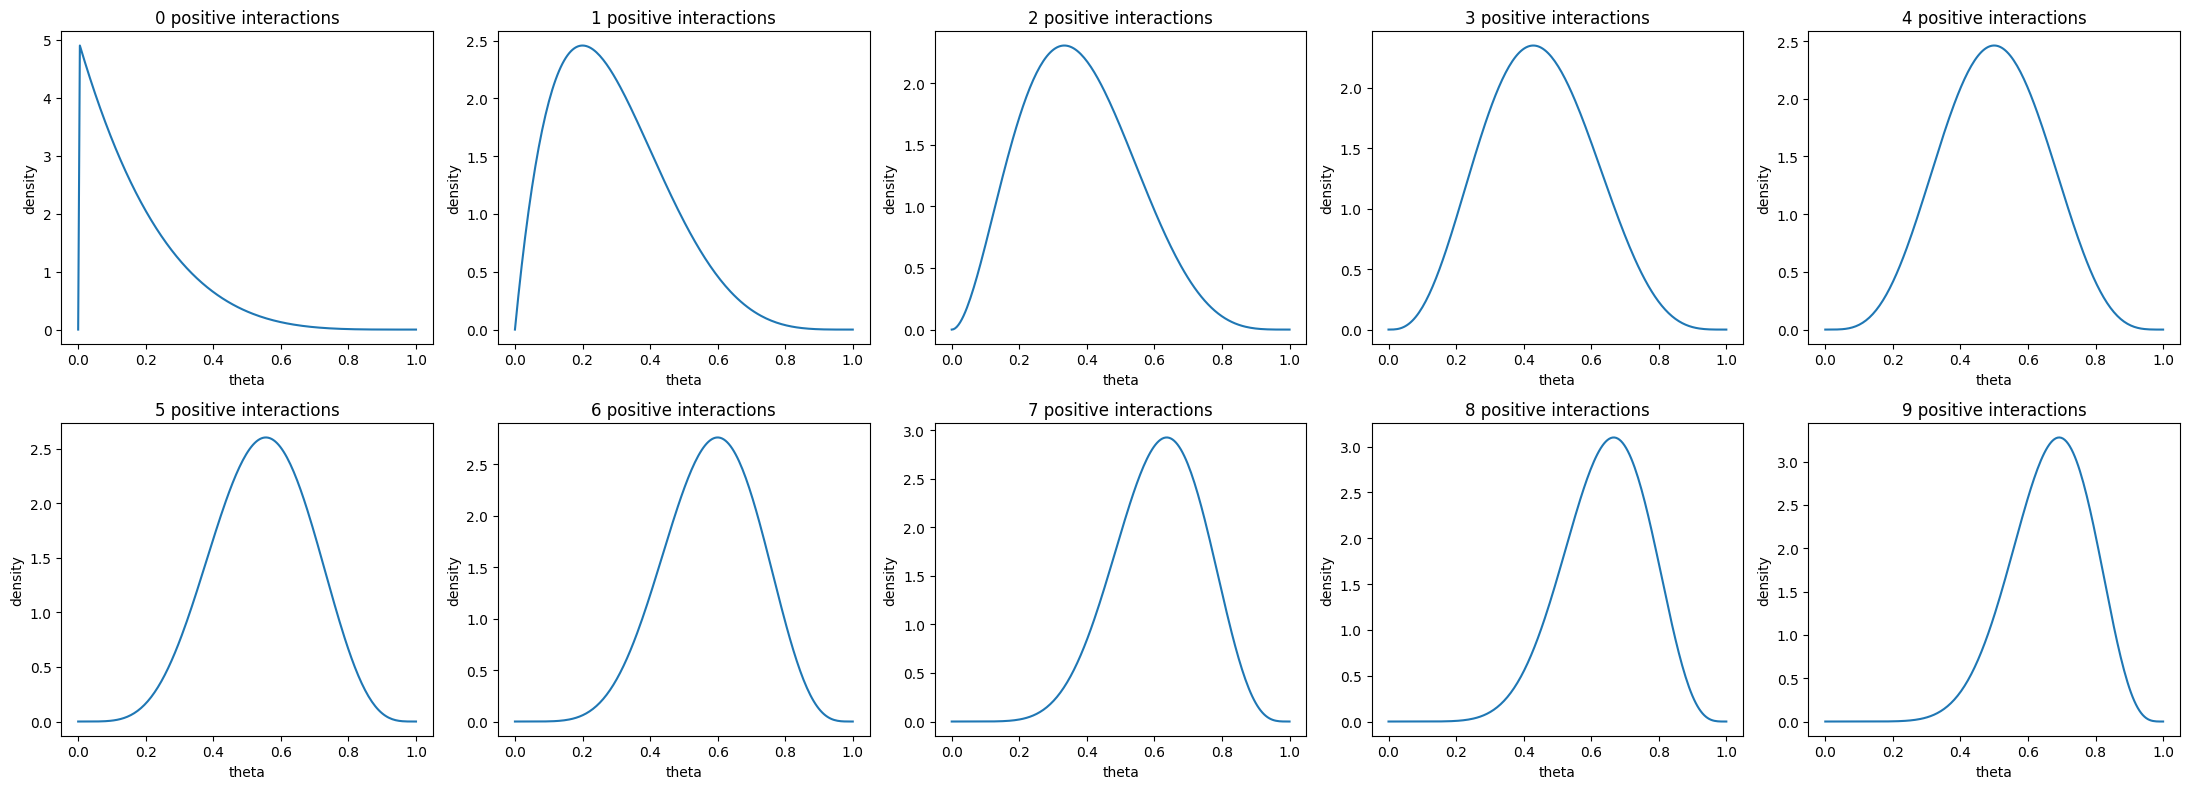

In [86]:
fig, ax = plt.subplots(2, 5, figsize = (22, 8))
for i in list(range(10)):
    a, b = agents[0].beta_communicate[agents[1]]
    _ = ax[int(i>4), i%5].plot(beta_communicate, st.beta.pdf(beta_communicate, a, b))
    _ = ax[int(i>4), i%5].set_xlabel("theta")
    _ = ax[int(i>4), i%5].set_ylabel("density")
    _ = ax[int(i>4), i%5].set_title(f"{i} positive interactions")

    agents[0].update_beta_communicate(agents[1], positive_outcome=True)
fig.tight_layout(w_pad=1, h_pad=1)